In [1]:
import numpy as np
from matplotlib import pyplot as plt
from astropy.io import fits
from astropy.coordinates import SkyCoord
from astropy import units as u
import os
import sys
from astropy.coordinates import ICRS, Galactic, FK4, FK5  # Low-level frames
from astropy.coordinates import Angle, Latitude, Longitude  # Angles
from mpl_toolkits.mplot3d import Axes3D
from astropy.cosmology import WMAP9 as cosmo
from astropy.constants import c
%matplotlib inline

/Users/kellywhalen/anaconda2/envs/py27/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [2]:
#Get current path so program can tell if this is being run on Kelly's or Rose's computer
mypath=os.getcwd()
if mypath.find('rfinn') > -1:
    print "Running on Rose's computer"
    #agcfile='/Users/rfinn/idl/programs/idl_alfa/agctotal.sav'
    gitpath='/Users/rfinn/github/'
    nsapath = '/Users/rfinn/research/NSA/'
    gswlpath = '/Users/rfinn/Dropbox/Research/GSWLC/'
    agcpath = '/Users/rfinn/research/AGC/'
elif mypath.find('kelly') > -1:
    print "Running on Kellys's computer"
    gitpath='/Users/kellywhalen/Github/'
    nsapath = '/Users/kellywhalen/RESEARCH/NSA_table/'
    gswlpath = '/Users/kellywhalen/RESEARCH/GSWLC/'
    agcpath = '/Users/kellywhalen/RESEARCH/AGC/'



Running on Kellys's computer


In [3]:
#Read in files needed to create plots
galex = fits.getdata(gitpath+'Virgo/tables/GALEX-WISE-allsky_virgo.fits')
#galexD = fits.getdata(gitpath+'Virgo/tables/GALEX-WISE-deepsky_virgo.fits')
#galexMID = fits.getdata(gitpath+'Virgo/tables/GALEX-WISE-mid_virgo.fits')
nsa = fits.getdata(gitpath+'Virgo/tables/VirgoCatalog.fits')
#nsa = fits.getdata('/Users/kellywhalen/Github/Virgo/tables/nsa_v0_1_2.fits')
nsadict=dict((a,b) for a,b in zip(nsa.NSAID,np.arange(len(nsa.NSAID))))
massFile = fits.getdata(gitpath+'Virgo/tables/StellarMasstoNSA_virgo.fits')
targets = fits.getdata(gitpath+'Virgo/tables/CO-HI_virgo.fits')
wise = fits.getdata(gitpath+'Virgo/tables/WISE_virgo.fits')
fullnsa = fits.getdata(nsapath + 'nsa_v0_1_2.fits' )

# Calculating Distances from Virgo Center

In [4]:
#Selecting Galaxies in the vicinity of Virgo
raflag = (nsa.RA > 115.) & (nsa.RA < 240.)
decflag= (nsa.DEC > -30.) & (nsa.DEC < 60.)
velflag =  (nsa.Z*3.e5 < 3000.) # & (nsa.Z*3.e5 > 1000.) 
vflag = raflag & decflag & velflag 

#nsa = nsa[vflag]

# define nsa RA and Dec as SkyCoord
nsa_sc = SkyCoord(nsa.RA*u.degree, nsa.DEC*u.degree)


# convert helio-centric velocity to units of km/s
V_H = nsa.Z*c.to('km/s')

# 1. correction of observed heliocentric velocity to centroid of local group
# VLG = VH - 79 cos l cos b + 296 sin l cos b - 36 sin b

V_LG = - 79.*u.km/u.second*np.cos(nsa_sc.galactic.l.radian)*np.cos(nsa_sc.galactic.b.radian) + 296.*u.km/u.second*np.sin(nsa_sc.galactic.l.radian)*np.cos(nsa_sc.galactic.b.radian) - 36.*u.km/u.second*np.sin(nsa_sc.galactic.b.radian)

# from Mould+2000, ApJ, 529, 786
# not sure if we are using this equation exactly right

V_fid = 200.*u.km/u.second # infall of LG into Virgo?
# Virgo coordinates given by Mould+2000
Virgo = SkyCoord('12h28m19s', '+12d40m00s', frame='fk5',equinox='J1950.') # epoch = 1950
Virgo = Virgo.transform_to(FK5(equinox='J2000'))
### need to fix this to use spherical distance
#theta = np.sqrt((nsa_sc.ra.radian - Virgo.ra.radian)**2 + (nsa_sc.dec.radian - Virgo.dec.radian)**2)
theta = Virgo.separation(nsa_sc).radian 
# cluster radius in deg
gamma = 2.

V_a = 1035.*u.km/u.second # recession vel of Virgo from Mould+2000
#V_a = 1221.*u.km/u.second # recession vel of Virgo as calculated by Gianluca
V_o = nsa.Z*c.to('km/s') + V_LG # recession velocities of the galaxies
r_oa = np.sqrt(V_o**2 + V_a**2 - 2.*V_o*V_a*np.cos(theta))
V_infall = V_fid*(np.cos(theta) + (V_o - V_a*np.cos(theta))/r_oa*(r_oa/V_a)**(1-gamma))
V_infall = 0

V_fid = 400.*u.km/u.second # infall of LG into Virgo?
# GA coordinates given by Mould+2000
GA = SkyCoord('13h20m00s', '+44d00m00s', frame='fk5',equinox='J1950.') # epoch = 1950
GA = GA.transform_to(FK5(equinox='J2000'))
theta = GA.separation(nsa_sc).radian
#theta = np.sqrt((nsa_sc.ra.radian - GA.ra.radian)**2 + (nsa_sc.dec.radian - GA.dec.radian)**2)

gamma = 2.
V_a = 4380.*u.km/u.second # recession vel of Great Attractor from Mould+2000
V_o = nsa.Z*c.to('km/s') + V_LG # recession velocities of the galaxies
r_oa = np.sqrt(V_o**2 + V_a**2 - 2.*V_o*V_a*np.cos(theta))
V_GA = V_fid*(np.cos(theta) + (V_o - V_a*np.cos(theta))/r_oa*(r_oa/V_a)**(1-gamma))

# Final, correction cosmic velocity is
#
#  Vcosmic = VH + Vc,LG + Vin,Virgo + Vin,GA + Vin,Shap + ...

# ## Tranforming to Supergalactic Coordinates##
# 
# Looking to match the plots shown in Kim+2016
# 
# https://arxiv.org/abs/1611.00437

#Plot of Virgo Cluster in galactic coordinates
V_cosmic = V_H + V_LG + V_infall +V_GA
V = V_cosmic

#SGX = V/cosmo.H(0)*np.cos(nsa_sc.supergalactic.sgl.radian)*np.cos(nsa_sc.supergalactic.sgb.radian)
#SGY = V/cosmo.H(0)*np.sin(nsa_sc.supergalactic.sgl.radian)*np.cos(nsa_sc.supergalactic.sgb.radian)
#SGZ = V/cosmo.H(0)*np.sin(nsa_sc.supergalactic.sgb.radian)


# using H0 = 74 to match Kim+2016 paper
#H0 = 74.*u.km/u.second/u.Mpc
H0 = 100.*u.km/u.second/u.Mpc #Kim's email
SGX = V/H0*np.cos(nsa_sc.supergalactic.sgl.radian)*np.cos(nsa_sc.supergalactic.sgb.radian)
SGY = V/H0*np.sin(nsa_sc.supergalactic.sgl.radian)*np.cos(nsa_sc.supergalactic.sgb.radian)
SGZ = V/H0*np.sin(nsa_sc.supergalactic.sgb.radian)

distance_to_virgo = 16.5*u.Mpc #Mpc
SGX_Virgo = distance_to_virgo*np.cos(Virgo.supergalactic.sgl.radian)*np.cos(Virgo.supergalactic.sgb.radian)
SGY_Virgo = distance_to_virgo*np.sin(Virgo.supergalactic.sgl.radian)*np.cos(Virgo.supergalactic.sgb.radian)
SGZ_Virgo = distance_to_virgo*np.sin(Virgo.supergalactic.sgb.radian)

# difference 
DSGX = SGX - SGX_Virgo
DSGY = SGY - SGY_Virgo
DSGZ = SGZ - SGZ_Virgo

distV = np.sqrt(DSGX**2 + DSGY**2 + DSGZ**2)

## SFR vs. Stellar Mass Plots (WISE data)

## Setting up SFRs and Stellar Masses

In [5]:
logSFR = wise.SFR
logMass = massFile.MSTAR_50

dataflag = (wise.CNTR_01 != 0) & (massFile.ISEDFIT_ID !=0)
sfrflag = wise.SFR != 0
targetflag = targets.IsInFilament != 0

### Virgo galaxies

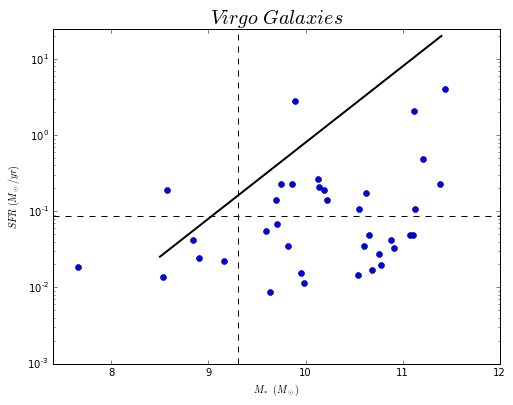

In [6]:
clusterFlag = (distV < 3.*u.Mpc) & dataflag

plt.figure(figsize = (8,6))
plt.plot(logMass[clusterFlag & sfrflag], logSFR[clusterFlag & sfrflag], 'bo')
plt.axis([7.4,12,.008,20])
xe=np.arange(8.5,11.5,.1)
xe=10.**xe
ye=(.08e-9)*xe
plt.plot(np.log10(xe),(ye),'k-',lw=2,label='Elbaz+2011')
plt.gca().set_yscale('log')
plt.axvline(x=9.3,c='k',ls='--')
plt.axhline(y=.086,c='k',ls='--')
#colorbar(sp,fraction=.08)
plt.axis([7.4,12,1.e-3,25])
plt.xlabel(r'$ M_* \ (M_\odot) $')
plt.ylabel('$ SFR \ (M_\odot/yr) $')
plt.title('$Virgo \ Galaxies$', fontsize = 20)



### All galaxies outside of Virgo

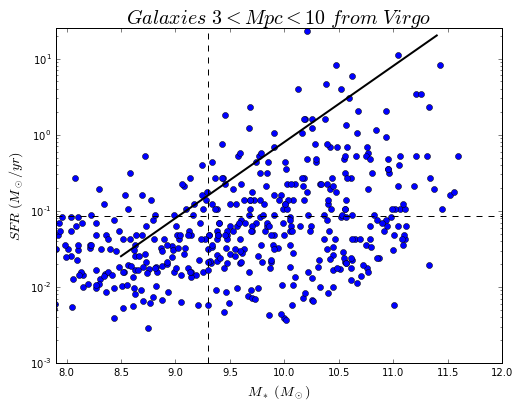

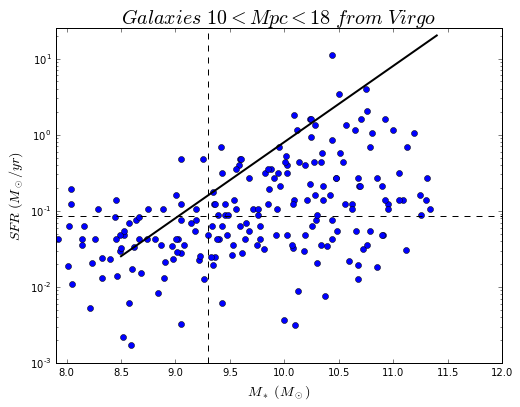

In [7]:
filamentFlag = (distV > 3.*u.Mpc) & (distV < 10.*u.Mpc) & dataflag 

plt.figure(figsize = (8,6))
plt.plot(logMass[filamentFlag & sfrflag], logSFR[filamentFlag & sfrflag], 'bo')
plt.xlabel('$log \ M$', fontsize = 14)
plt.ylabel('$log \ SFR$', fontsize = 14)
plt.axis([7.4,12,.008,20])
xe=np.arange(8.5,11.5,.1)
xe=10.**xe
ye=(.08e-9)*xe
plt.plot(np.log10(xe),(ye),'k-',lw=2,label='Elbaz+2011')
plt.gca().set_yscale('log')
plt.axvline(x=9.3,c='k',ls='--')
plt.axhline(y=.086,c='k',ls='--')
#colorbar(sp,fraction=.08)
plt.axis([7.9,12,1.e-3,25])
plt.xlabel(r'$ M_* \ (M_\odot) $')
plt.ylabel('$ SFR \ (M_\odot/yr) $')
plt.title('$Galaxies \ 3 < Mpc < 10 \ from \ Virgo$', fontsize = 20)


filamentFlag = (distV > 10.*u.Mpc) & (distV < 18.*u.Mpc) & dataflag 

plt.figure(figsize = (8,6))
plt.plot(logMass[filamentFlag & sfrflag], logSFR[filamentFlag & sfrflag], 'bo')
plt.xlabel('$log \ M$', fontsize = 14)
plt.ylabel('$log \ SFR$', fontsize = 14)
plt.axis([7.4,12,.008,20])
xe=np.arange(8.5,11.5,.1)
xe=10.**xe
ye=(.08e-9)*xe
plt.plot(np.log10(xe),(ye),'k-',lw=2,label='Elbaz+2011')
plt.gca().set_yscale('log')
plt.axvline(x=9.3,c='k',ls='--')
plt.axhline(y=.086,c='k',ls='--')
#colorbar(sp,fraction=.08)
plt.axis([7.9,12,1.e-3,25])
plt.xlabel(r'$ M_* \ (M_\odot) $')
plt.ylabel('$ SFR \ (M_\odot/yr) $')
plt.title('$Galaxies \ 10 < Mpc < 18 \ from \ Virgo$', fontsize = 20)

### Identified Filament Galaxies- As Seen in Jablonka Targets

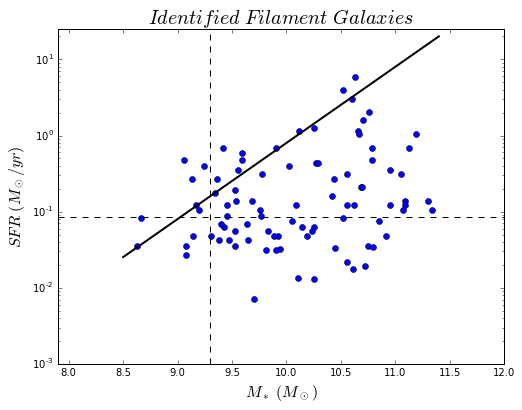

In [8]:
filamentFlag = (distV > 3.*u.Mpc) & (distV < 18.*u.Mpc) & dataflag & targetflag

plt.figure(figsize = (8,6))
plt.plot(logMass[filamentFlag & sfrflag], logSFR[filamentFlag & sfrflag], 'bo')
plt.xlabel('$log \ M$', fontsize = 16)
plt.ylabel('$log \ SFR$', fontsize = 16)
plt.axis([7.4,12,.008,20])
xe=np.arange(8.5,11.5,.1)
xe=10.**xe
ye=(.08e-9)*xe
plt.plot(np.log10(xe),(ye),'k-',lw=2,label='Elbaz+2011')
plt.gca().set_yscale('log')
plt.axvline(x=9.3,c='k',ls='--')
plt.axhline(y=.086,c='k',ls='--')
#colorbar(sp,fraction=.08)
plt.axis([7.9,12,1.e-3,25])
plt.xlabel(r'$ M_* \ (M_\odot) $')
plt.ylabel('$ SFR \ (M_\odot/yr) $')
plt.title('$Identified \ Filament \ Galaxies$', fontsize = 20)

# NUV-r vs. r-22 Plots

### Virgo galaxies

/Users/kellywhalen/anaconda2/envs/py27/lib/python2.7/site-packages/ipykernel/__main__.py:2: RuntimeWarning: divide by zero encountered in log10
  from ipykernel import kernelapp as app
/Users/kellywhalen/anaconda2/envs/py27/lib/python2.7/site-packages/ipykernel/__main__.py:2: RuntimeWarning: invalid value encountered in log10
  from ipykernel import kernelapp as app


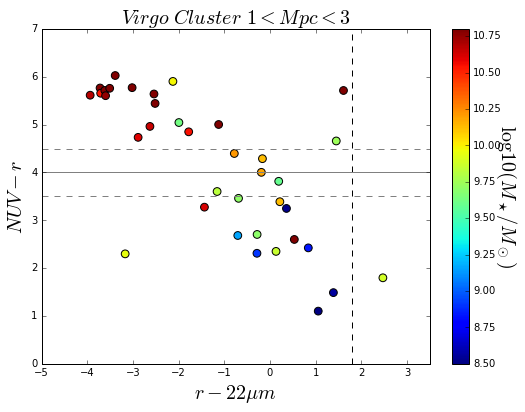

In [9]:
#NUV-r
nsa.nsamag = 22.5-2.5*np.log10(nsa.NMGY)
NUVr = nsa.ABSMAG[:,1] - nsa.ABSMAG[:,4]
wflag = (wise.W4MPRO > 0.1) & (wise.W4SNR > 3.)

cflag =  wflag  & clusterFlag

r22 = nsa.nsamag[:,4] - (wise.W4MPRO + 6.620) #convert to AB magnitude

#Define stellar mass
plt.figure(figsize = (8,6))
plt.scatter(r22[cflag], NUVr[cflag], c=logMass[cflag], s = 60, vmin = 8.5, vmax = 10.8)
cb = plt.colorbar(fraction = 0.08)
plt.axis([-5,3.5,0,7])
plt.xlabel('$r - 22\mu m$', fontsize=20)
plt.ylabel('$NUV-r$', fontsize=20)
plt.axvline(x=1.8,ls='--',color='k')
plt.axhline(y=4,ls='-',color='0.5')
plt.axhline(y=4.5,ls='--',color='0.5')
plt.axhline(y=3.5,ls='--',color='0.5')
cb.ax.text(2.5, .5,'$\log{10}(M_\star/M_\odot)$', rotation = -90, verticalalignment = 'center', fontsize = 20)
plt.title('$Virgo\ Cluster \ 1 < Mpc <3$', fontsize = 20)


### All galaxies outside of Virgo

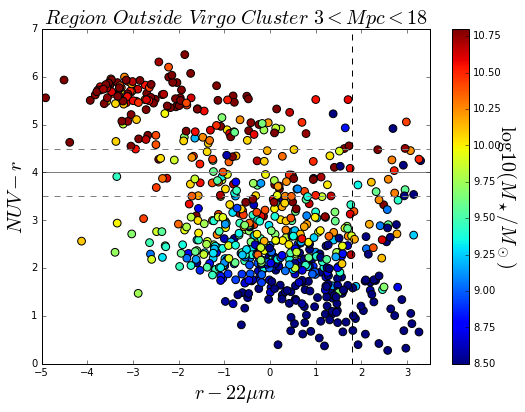

In [10]:
filamentFlag = (distV > 3.*u.Mpc) & (distV < 18.*u.Mpc) & dataflag 
cflag =  wflag  & filamentFlag
plt.figure(figsize = (8,6))
plt.scatter(r22[cflag], NUVr[cflag], c=logMass[cflag], s = 60, vmin = 8.5, vmax = 10.8)
cb = plt.colorbar(fraction = 0.08)
plt.axis([-5,3.5,0,7])
plt.xlabel('$r - 22\mu m$', fontsize=20)
plt.ylabel('$NUV-r$', fontsize=20)
plt.axvline(x=1.8,ls='--',color='k')
plt.axhline(y=4,ls='-',color='0.5')
plt.axhline(y=4.5,ls='--',color='0.5')
plt.axhline(y=3.5,ls='--',color='0.5')
cb.ax.text(2.5, .5,'$\log{10}(M_\star/M_\odot)$', rotation = -90, verticalalignment = 'center', fontsize = 20)
plt.title('$Region \ Outside \ Virgo\ Cluster \ 3 < Mpc <18$', fontsize = 20)



### Identified Filament Galaxies- As Seen in Jablonka Targets

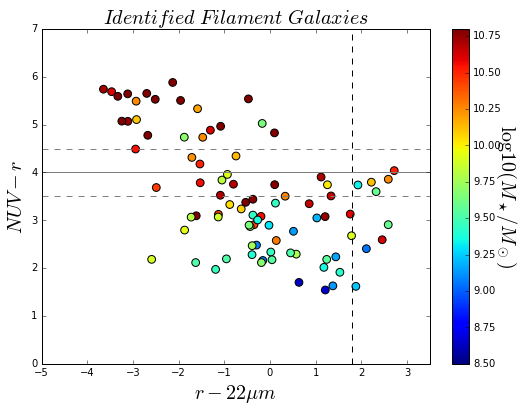

In [11]:
filamentFlag = (distV > 3.*u.Mpc) & (distV < 18.*u.Mpc) & dataflag & targetflag
cflag =  wflag  & filamentFlag
plt.figure(figsize = (8,6))
plt.scatter(r22[cflag], NUVr[cflag], c=logMass[cflag], s = 60, vmin = 8.5, vmax = 10.8)
cb = plt.colorbar(fraction = 0.08)
plt.axis([-5,3.5,0,7])
plt.xlabel('$r - 22\mu m$', fontsize=20)
plt.ylabel('$NUV-r$', fontsize=20)
plt.axvline(x=1.8,ls='--',color='k')
plt.axhline(y=4,ls='-',color='0.5')
plt.axhline(y=4.5,ls='--',color='0.5')
plt.axhline(y=3.5,ls='--',color='0.5')
cb.ax.text(2.5, .5,'$\log{10}(M_\star/M_\odot)$', rotation = -90, verticalalignment = 'center', fontsize = 20)
plt.title('$Identified \ Filament \ Galaxies$', fontsize = 20)



# NUV-r vs. Mass Plots

### Virgo galaxies

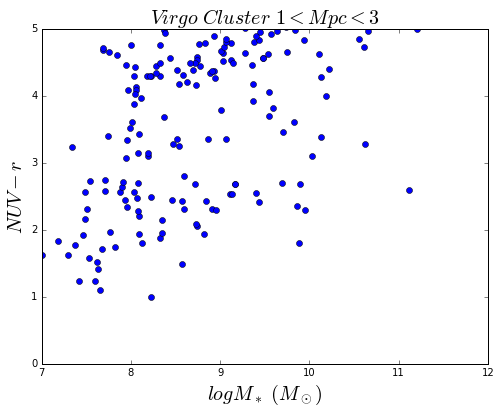

In [12]:
clusterFlag =  (distV < 3.*u.Mpc) & (massFile.ISEDFIT_ID !=0)
plt.figure(figsize = (8,6))
plt.axis([7.,12.,0.,5.])
plt.plot(logMass[clusterFlag], NUVr[clusterFlag], 'bo')
plt.xlabel('$ log M_* \ (M_\odot) $', fontsize=20)
plt.ylabel('$NUV-r$', fontsize=20)
plt.title('$Virgo\ Cluster \ 1 < Mpc <3$', fontsize = 20)



### Galaxies in the region around Virgo

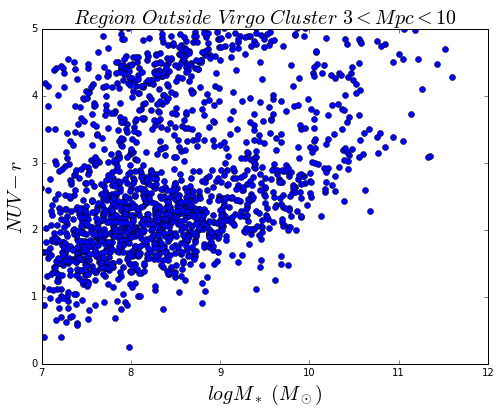

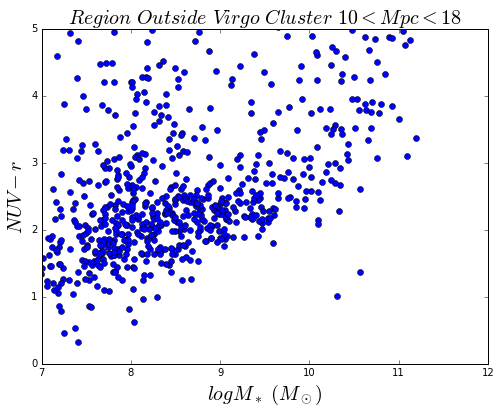

In [13]:
filamentFlag = (distV > 3.*u.Mpc) & (distV < 10.*u.Mpc) & (massFile.ISEDFIT_ID !=0)

plt.figure(figsize = (8,6))
plt.hexbin(nsa.ABSMAG[:,4],nsa.ABSMAG[:,1]-nsa.ABSMAG[:,4],gridsize=250,cmap='gray_r')
plt.axis([7.,12.,0.,5.])
plt.plot(logMass[filamentFlag], NUVr[filamentFlag], 'bo')
plt.xlabel('$ log M_* \ (M_\odot) $', fontsize=20)
plt.ylabel('$NUV-r$', fontsize=20)
plt.title('$Region \ Outside \ Virgo\ Cluster \ 3 < Mpc <10$', fontsize = 20)

filamentFlag = (distV > 10.*u.Mpc) & (distV < 18.*u.Mpc) & (massFile.ISEDFIT_ID !=0)

plt.figure(figsize = (8,6))
plt.axis([7.,12.,0.,5.])
plt.plot(logMass[filamentFlag], NUVr[filamentFlag], 'bo')
plt.xlabel('$ log M_* \ (M_\odot) $', fontsize=20)
plt.ylabel('$NUV-r$', fontsize=20)
plt.title('$Region \ Outside \ Virgo\ Cluster \ 10 < Mpc <18$', fontsize = 20)

### Identified Filaments

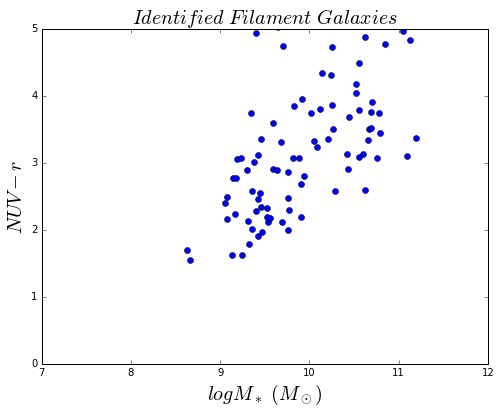

In [14]:
filamentFlag = (distV > 3.*u.Mpc) & (distV < 18.*u.Mpc) & (massFile.ISEDFIT_ID !=0) & targetflag

plt.figure(figsize = (8,6))
plt.axis([7.,12.,0.,5.])
plt.plot(logMass[filamentFlag], NUVr[filamentFlag], 'bo')
plt.xlabel('$ log M_* \ (M_\odot) $', fontsize=20)
plt.ylabel('$NUV-r$', fontsize=20)
plt.title('$Identified \ Filament \ Galaxies$', fontsize = 20)

# Figure 1 from Kim+2016

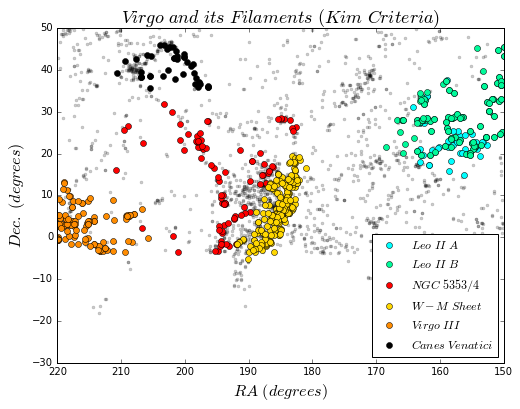

In [15]:
raflag = (nsa.RA > 150.) & (nsa.RA < 220.)
decflag= (nsa.DEC > -30.) & (nsa.DEC < 50.)
velflag = (nsa.Z*3.e5 > 1000.) & (nsa.Z*3.e5 < 3000.)
vflag = raflag & decflag & velflag 
c = 3.e5
z = nsa.Z

leoIIa = vflag & (SGX > 0.21*u.Mpc) & (SGX < 10.36*u.Mpc) & (SGY > 9.26*u.Mpc) & (SGY < 15.05*u.Mpc) & (SGZ > -15.47*u.Mpc) & (SGZ < -4.16*u.Mpc) & (c*z > 1171) & (c*z < 2267)
leoIIb = vflag & (SGX > 0.30*u.Mpc) & (SGX < 15.65*u.Mpc) & (SGY > 10.90*u.Mpc) & (SGY < 14.56*u.Mpc) & (SGZ > -9.88*u.Mpc) & (SGZ < -3.51*u.Mpc) & (c*z >  1257) & (c*z < 2267)
ngc = vflag & (SGX > -16.04*u.Mpc) & (SGX < 4.23*u.Mpc) & (SGY > 21.71 *u.Mpc) & (SGY < 26.53*u.Mpc) & (SGZ > -1.19 *u.Mpc) & (SGZ < 8.92*u.Mpc) & (c*z >  2268) & (c*z < 3238)
wm = vflag & (SGX > -13.38*u.Mpc) & (SGX < -1.66*u.Mpc) & (SGY > 16.03  *u.Mpc) & (SGY < 24.99*u.Mpc) & (SGZ > -3.10 *u.Mpc) & (SGZ < -1.10*u.Mpc) & (c*z > 1806) & (c*z < 2968)
vIII = vflag & (SGX > -10.56*u.Mpc) & (SGX < -3.91*u.Mpc) & (SGY >  9.50  *u.Mpc) & (SGY < 15.57*u.Mpc) & (SGZ >  2.35 *u.Mpc) & (SGZ < 11.72*u.Mpc) & (c*z > 1160) & (c*z < 2196)
canes = vflag & (SGX > 0.78 *u.Mpc) & (SGX < 4.37*u.Mpc) & (SGY >   6.88   *u.Mpc) & (SGY < 13.92*u.Mpc) & (SGZ >  1.38  *u.Mpc) & (SGZ < 4.80*u.Mpc) & (c*z >   674 ) & (c*z < 1446)


plt.figure(figsize = (8,6))
plt.plot(nsa.RA[vflag], nsa.DEC[vflag], 'k.', alpha=0.2)
plt.plot(nsa.RA[leoIIa], nsa.DEC[leoIIa], color = 'aqua', marker = 'o', linestyle = 'None', label = '$Leo\ II\ A$')
plt.plot(nsa.RA[leoIIb], nsa.DEC[leoIIb], color = 'mediumspringgreen', marker = 'o', linestyle = 'None', label = '$Leo\ II\ B$')  
plt.plot(nsa.RA[ngc], nsa.DEC[ngc], 'ro', label = '$NGC\ 5353/4$') 
plt.plot(nsa.RA[wm], nsa.DEC[wm], color = 'gold', marker = 'o', linestyle = 'None', label = '$W-M\ Sheet$')
plt.plot(nsa.RA[vIII], nsa.DEC[vIII], color = 'darkorange', marker = 'o', linestyle = 'None', label = '$Virgo \ III$')
plt.plot(nsa.RA[canes], nsa.DEC[canes], 'ko', label = '$Canes\ Venatici$')
plt.xlabel('$RA\ (degrees)$', fontsize = 16)
plt.ylabel('$Dec.\ (degrees)$', fontsize = 16)
plt.title('$Virgo\ and \ its \ Filaments\ (Kim\ Criteria)$', fontsize = 18)
plt.legend(loc='lower right', numpoints = 1)
plt.gca().invert_xaxis()
plt.axis([220.,150.,-30.,50.])
plt.savefig('virgofilaments.png')

### Jablonka CO-Targets Kim Figure 1

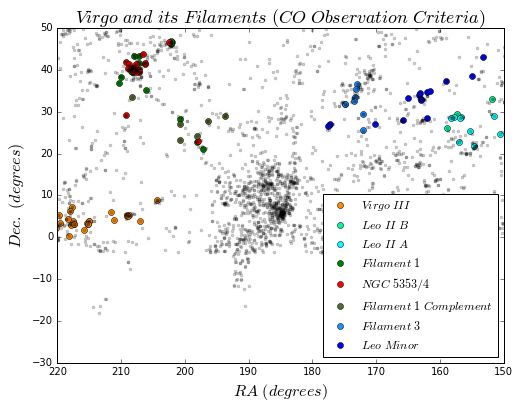

In [16]:
VirgoIIIw = (targets.filament == 'Virgo-III-WESTR-exte')
VirgoIIIc = (targets.filament == 'Virgo-III-centre')
leoIIB = (targets.filament == 'LeoII-B')
lmf4 = (targets.filament == 'LeoMinor-Filament-4')
leoIIA = (targets.filament == 'LeoII_A')
fil1 = (targets.filament == 'Filament1')
n5353 = (targets.filament == 'N5353-group')
fil1com = (targets.filament == 'Filament1-complement')
fil3 = (targets.filament == 'Filament3')



plt.figure(figsize = (8,6))
plt.plot(nsa.RA[VirgoIIIw], nsa.DEC[VirgoIIIw],color = 'darkorange', marker = 'o', linestyle = 'None', label = '$Virgo \ III$')
plt.plot(nsa.RA[VirgoIIIc], nsa.DEC[VirgoIIIc], color = 'darkorange', marker = 'o', linestyle = 'None')
plt.plot(nsa.RA[leoIIB], nsa.DEC[leoIIB], color = 'mediumspringgreen', marker = 'o', linestyle = 'None', label = '$Leo\ II\ B$')
plt.plot(nsa.RA[leoIIA], nsa.DEC[leoIIA], color = 'aqua', marker = 'o', linestyle = 'None', label = '$Leo\ II\ A$')
plt.plot(nsa.RA[fil1], nsa.DEC[fil1], 'go',label = '$Filament\ 1$')
plt.plot(nsa.RA[n5353], nsa.DEC[n5353], 'ro', label = '$NGC\ 5353/4$')
plt.plot(nsa.RA[fil1com], nsa.DEC[fil1com], c='darkolivegreen', marker='o', linestyle='None', label = '$Filament\ 1\ Complement$')
plt.plot(nsa.RA[fil3], nsa.DEC[fil3], c='dodgerblue', marker='o', linestyle='None', label = '$Filament\ 3$')
plt.plot(nsa.RA[lmf4], nsa.DEC[lmf4], 'bo', label = '$Leo \ Minor$')
plt.plot(nsa.RA[vflag], nsa.DEC[vflag], 'k.', alpha=0.2)
plt.gca().invert_xaxis()
plt.axis([220.,150.,-30.,50.])
plt.legend(loc='lower right', numpoints = 1)
plt.xlabel('$RA\ (degrees)$', fontsize = 16)
plt.ylabel('$Dec.\ (degrees)$', fontsize = 16)
plt.title('$Virgo\ and \ its \ Filaments\ (CO\ Observation \ Criteria)$', fontsize = 18)
plt.legend(loc='lower right', numpoints = 1)
plt.savefig('CO_virgo.png')

# NUV-r vs. R Plots

## Virgo Cluster

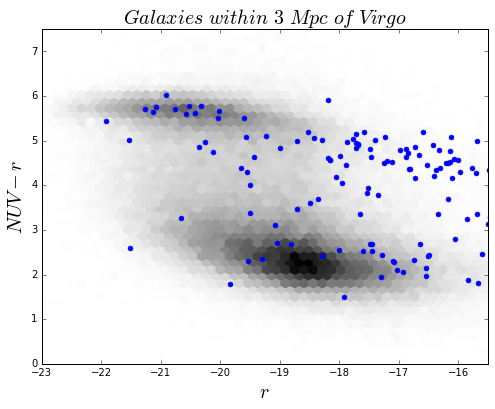

In [17]:
clusterFlag = (distV < 3.*u.Mpc)
plt.figure(figsize = (8,6))
plt.hexbin(fullnsa.ABSMAG[:,4],fullnsa.ABSMAG[:,1]-fullnsa.ABSMAG[:,4],gridsize=250,cmap='gray_r')
plt.plot(nsa.ABSMAG[:,4][clusterFlag],nsa.ABSMAG[:,1][clusterFlag]-nsa.ABSMAG[:,4][clusterFlag], '.', ms=10)
plt.axis([-23,-15.5,0.,7.5])
plt.xlabel('$ r $', fontsize=20)
plt.ylabel('$NUV-r$', fontsize=20)
plt.title('$Galaxies\ within\ 3\ Mpc\ of\ Virgo$', fontsize = 20)

## Identified Kim Filament Galaxies

[-23, -15.5, 0.0, 7.5]

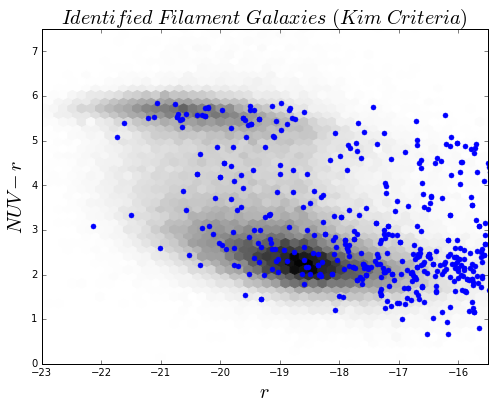

In [18]:
plt.figure(figsize = (8,6))
plt.hexbin(fullnsa.ABSMAG[:,4],fullnsa.ABSMAG[:,1]-fullnsa.ABSMAG[:,4],gridsize=250,cmap='gray_r')
plt.plot(nsa.ABSMAG[:,4][leoIIa],nsa.ABSMAG[:,1][leoIIa]-nsa.ABSMAG[:,4][leoIIa], 'b.', ms=10)
plt.plot(nsa.ABSMAG[:,4][leoIIb],nsa.ABSMAG[:,1][leoIIb]-nsa.ABSMAG[:,4][leoIIb], 'b.', ms=10)
plt.plot(nsa.ABSMAG[:,4][ngc],nsa.ABSMAG[:,1][ngc]-nsa.ABSMAG[:,4][ngc], 'b.', ms=10)
plt.plot(nsa.ABSMAG[:,4][wm],nsa.ABSMAG[:,1][wm]-nsa.ABSMAG[:,4][wm], b'.', ms=10)
plt.plot(nsa.ABSMAG[:,4][vIII],nsa.ABSMAG[:,1][vIII]-nsa.ABSMAG[:,4][vIII], 'b.', ms=10)
plt.plot(nsa.ABSMAG[:,4][canes],nsa.ABSMAG[:,1][canes]-nsa.ABSMAG[:,4][canes], 'b.', ms=10)
plt.xlabel('$ r $', fontsize=20)
plt.ylabel('$NUV-r$', fontsize=20)
plt.title('$Identified \ Filament \ Galaxies\ (Kim\ Criteria)$', fontsize = 20)
plt.axis([-23,-15.5,0.,7.5])

## Jablonka Identified Targets

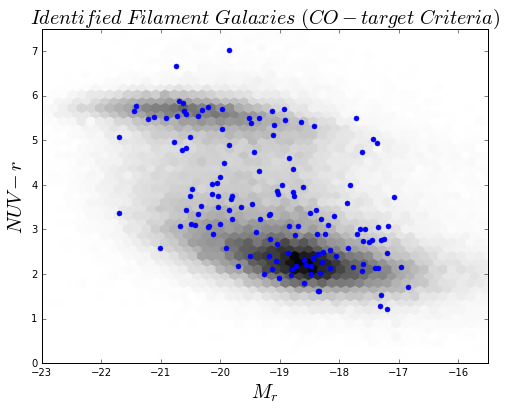

In [22]:
plt.figure(figsize = (8,6))
plt.hexbin(fullnsa.ABSMAG[:,4],fullnsa.ABSMAG[:,1]-fullnsa.ABSMAG[:,4],gridsize=250,cmap='gray_r')
plt.plot(nsa.ABSMAG[:,4][targetflag],nsa.ABSMAG[:,1][targetflag]-nsa.ABSMAG[:,4][targetflag], 'b.', ms=10)
plt.xlabel('$M_r $',fontsize=20)
plt.ylabel('$NUV-r$', fontsize=20)
plt.title('$Identified \ Filament \ Galaxies\ (CO-target\ Criteria)$', fontsize = 20)
plt.axis([-23,-15.5,0.,7.5])
plt.savefig('targets_color.png')

## Region Outside of Virgo

[-23, -15.5, 0.0, 7.5]

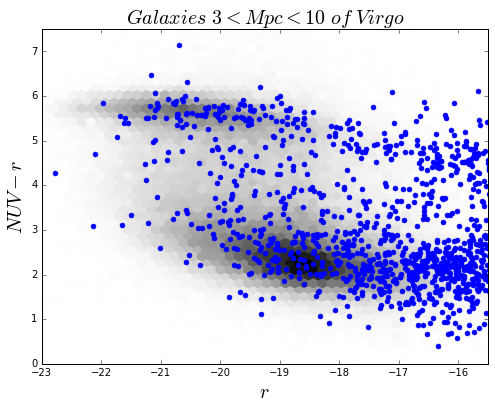

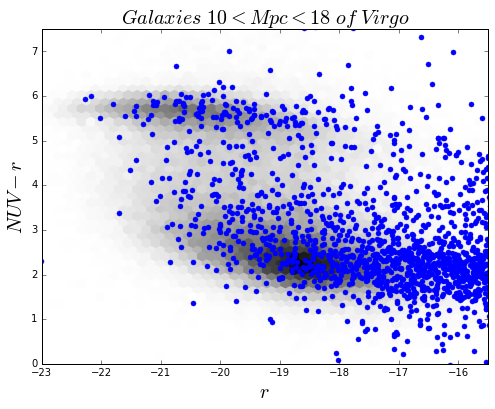

In [20]:
filamentFlag1 = (distV > 3.*u.Mpc) & (distV < 10.*u.Mpc)
filamentFlag2 = (distV > 10.*u.Mpc) & (distV < 18.*u.Mpc)

plt.figure(figsize = (8,6))
plt.hexbin(fullnsa.ABSMAG[:,4],fullnsa.ABSMAG[:,1]-fullnsa.ABSMAG[:,4],gridsize=250,cmap='gray_r')
plt.plot(nsa.ABSMAG[:,4][filamentFlag1],nsa.ABSMAG[:,1][filamentFlag1]-nsa.ABSMAG[:,4][filamentFlag1], 'b.', ms=10)
plt.xlabel('$ r $', fontsize=20)
plt.ylabel('$NUV-r$', fontsize=20)
plt.title('$Galaxies\ 3<Mpc<10\ of \ Virgo$', fontsize = 20)
plt.axis([-23,-15.5,0.,7.5])

plt.figure(figsize = (8,6))
plt.hexbin(fullnsa.ABSMAG[:,4],fullnsa.ABSMAG[:,1]-fullnsa.ABSMAG[:,4],gridsize=250,cmap='gray_r')
plt.plot(nsa.ABSMAG[:,4][filamentFlag2],nsa.ABSMAG[:,1][filamentFlag2]-nsa.ABSMAG[:,4][filamentFlag2], 'b.', ms=10)
plt.xlabel('$ r $', fontsize=20)
plt.ylabel('$NUV-r$', fontsize=20)
plt.title('$Galaxies\ 10<Mpc<18\ of \ Virgo$', fontsize = 20)
plt.axis([-23,-15.5,0.,7.5])

4.89736608488 Mpc
11.6026341053 Mpc
11.6026341053 Mpc
13.0790686235 Mpc s / km
187.70592077
12.3911375637
1307.90686235
1160.26341053 km / s
-116.58916658 km / s
-30.1494980862 km / s
1307.0020752 km / s


TypeError: 'int' object has no attribute '__getitem__'

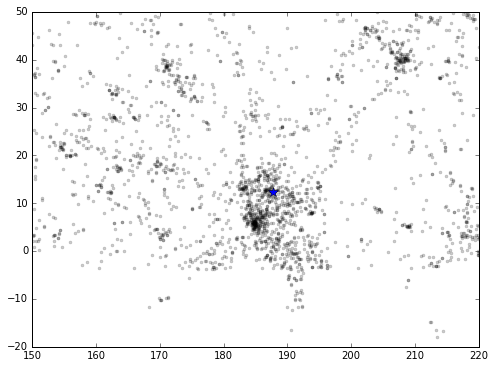

In [21]:
M87index = nsadict[141541]
plt.figure(figsize = (8,6))
plt.plot(nsa.RA[vflag], nsa.DEC[vflag], 'k.', alpha=0.2)
plt.plot(nsa.RA[M87index], nsa.DEC[M87index], 'b*', ms = 10)

print distV[M87index]
print V[M87index]/H0
print V[M87index]/H0
print nsa.Z[M87index]*3.e5/H0
print nsa.RA[M87index]
print nsa.DEC[M87index]
print nsa.Z[M87index]*3.e5
print V[M87index]
print V_LG[M87index]
print V_GA[M87index]
print V_H[M87index]
print V_infall[M87index]

In [ ]:
plt.figure()
plt.hist(distV)

In [ ]:
V_fid = 200.*u.km/u.second # infall of LG into Virgo?
# Virgo coordinates given by Mould+2000
Virgo = SkyCoord('12h28m19s', '+12d40m00s', frame='fk5',equinox='J1950.') # epoch = 1950
Virgo = Virgo.transform_to(FK5(equinox='J2000'))
### need to fix this to use spherical distance
#theta = np.sqrt((nsa_sc.ra.radian - Virgo.ra.radian)**2 + (nsa_sc.dec.radian - Virgo.dec.radian)**2)
theta = Virgo.separation(nsa_sc).radian 
# cluster radius in deg
gamma = 2.

V_a = 1035.*u.km/u.second # recession vel of Virgo from Mould+2000
#V_a = 1221.*u.km/u.second # recession vel of Virgo as calculated by Gianluca
V_o = nsa.Z*c.to('km/s') + V_LG # recession velocities of the galaxies
r_oa = np.sqrt(V_o**2 + V_a**2 - 2.*V_o*V_a*np.cos(theta))
V_infall = (V_fid*np.cos(theta)) +  V_fid*((V_o - V_a*np.cos(theta))/r_oa)*((r_oa/V_a)**(1-gamma))

print r_oa[M87index]
print V_infall[M87index]
print theta[M87index]